Grid Search Progress: 100%|██████████| 32/32 [00:03<00:00,  8.28it/s]


Best Parameters: {'k': 3, 'metric': 'manhattan', 'weights': 'distance', 'p': 1}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       122
           1       0.77      0.97      0.86       109

    accuracy                           0.85       231
   macro avg       0.87      0.86      0.85       231
weighted avg       0.87      0.85      0.85       231



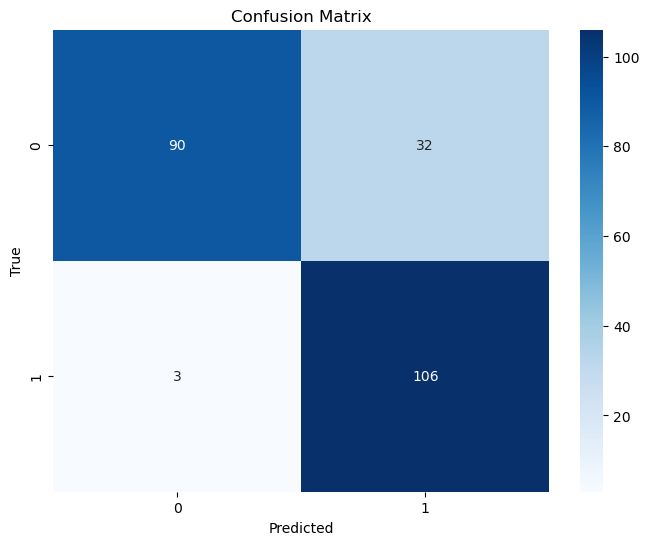

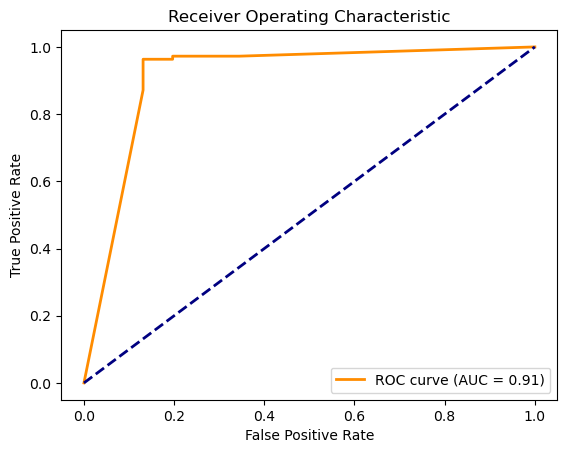

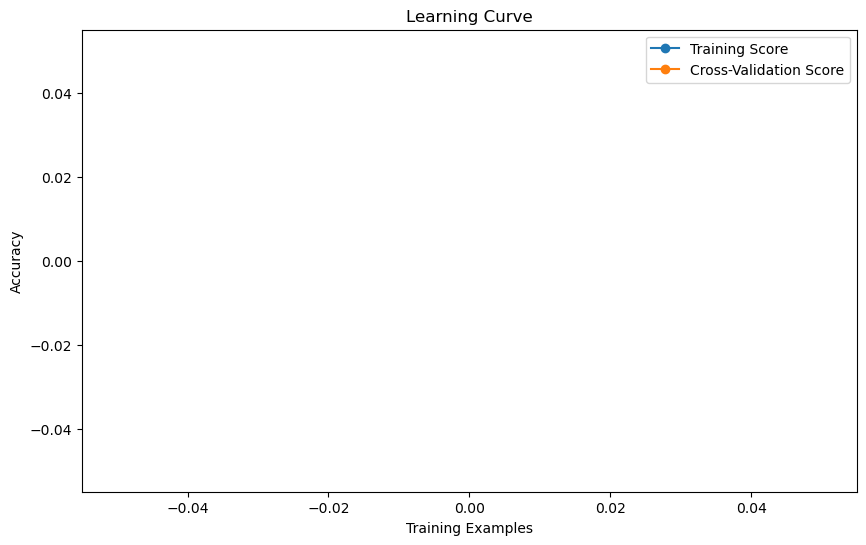

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (45,) and arg 3 with shape (31,).

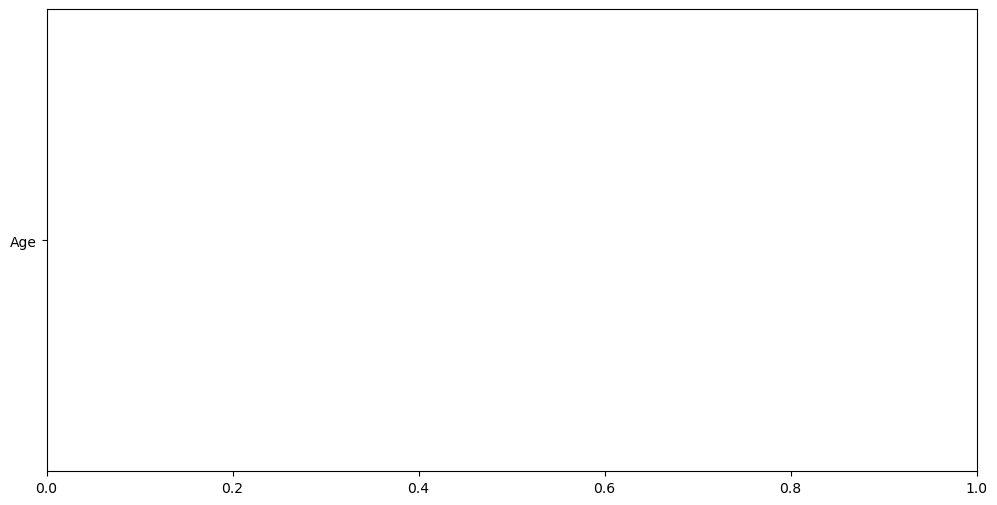

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from itertools import product

# ======================
# Data Preparation
# ======================

class DataPreprocessor:
    def __init__(self, upsample=True, scale_features=True):
        self.upsample = upsample
        self.scale_features = scale_features
        self.scaler = None
        self.feature_names = None
        
    def _encode_features(self, df):
        # Save feature names before encoding
        self.feature_names = df.drop("Attrition", axis=1).columns.tolist()
        
        # Convert categorical variables
        df = pd.get_dummies(df, columns=["Department", "EducationField", "Gender", 
                                       "JobRole", "MaritalStatus", "OverTime",
                                       "BusinessTravel"], drop_first=True)
        return df
    
    def _handle_imbalance(self, X, y):
        if self.upsample:
            X_resampled, y_resampled = resample(X[y == 1], y[y == 1], 
                                               replace=True, n_samples=X[y == 0].shape[0], 
                                               random_state=42)
            return np.vstack((X[y == 0], X_resampled)), np.hstack((y[y == 0], y_resampled))
        return X, y
    
    def _scale_features(self, X):
        if self.scale_features:
            if self.scaler is None:
                self.scaler = StandardScaler()
                return self.scaler.fit_transform(X)
            return self.scaler.transform(X)
        return X
    
    def preprocess(self, df):
        df = self._encode_features(df)
        X = df.drop("Attrition", axis=1).values
        y = df["Attrition"].values
        X, y = self._handle_imbalance(X, y)
        return self._scale_features(X), y
# ======================
# Advanced KNN Implementation
# ======================

class AdvancedKNN:
    def __init__(self, k=5, metric='euclidean', weights='uniform', p=2):
        self.k = k
        self.metric = metric
        self.weights = weights
        self.p = p
        self.X_train = None
        self.y_train = None
        self.classes_ = None
        self.feature_importances_ = None
        
        self._validate_parameters()
        
    def _validate_parameters(self):
        if not isinstance(self.k, int) or self.k <= 0:
            raise ValueError("k must be a positive integer")
        if self.metric not in ['euclidean', 'manhattan', 'minkowski']:
            raise ValueError("Invalid distance metric")
        if self.weights not in ['uniform', 'distance']:
            raise ValueError("Invalid weighting scheme")
            
    def _distance(self, a, b):
        """Calculate distance between two vectors"""
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((a - b)**2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(a - b), axis=1)
        elif self.metric == 'minkowski':
            return np.sum(np.abs(a - b)**self.p, axis=1)**(1/self.p)
            
    def _get_weights(self, distances):
        """Calculate instance weights based on distances"""
        if self.weights == 'uniform':
            return np.ones_like(distances)
        elif self.weights == 'distance':
            return 1 / (distances + 1e-8)  # Avoid division by zero
            
    def fit(self, X, y):
        """Store training data and extract class information"""
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
        
    def predict_proba(self, X):
        """Calculate class probabilities for input samples"""
        proba = []
        for x in X:
            distances = self._distance(x, self.X_train)
            indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[indices]
            weights = self._get_weights(distances[indices])
            
            class_weights = {}
            for cls in self.classes_:
                mask = (k_nearest_labels == cls)
                class_weights[cls] = np.sum(weights[mask])
                
            total = sum(class_weights.values())
            proba.append([class_weights.get(cls, 0)/total for cls in self.classes_])
            
        return np.array(proba)
    
    def predict(self, X):
        """Predict class labels for input samples"""
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]
    
    def score(self, X, y):
        """Calculate accuracy score"""
        return np.mean(self.predict(X) == y)
    
    def feature_importance(self, X_val, y_val, n_permutations=10):
        """Calculate permutation feature importance"""
        baseline_score = self.score(X_val, y_val)
        importances = np.zeros(X_val.shape[1])
        
        for i in range(X_val.shape[1]):
            temp = X_val.copy()
            perm_scores = []
            
            for _ in range(n_permutations):
                np.random.shuffle(temp[:, i])
                perm_score = self.score(temp, y_val)
                perm_scores.append(baseline_score - perm_score)
                
            importances[i] = np.mean(perm_scores)
            
        self.feature_importances_ = importances / importances.sum()
        return self.feature_importances_

# ======================
# Model Evaluation
# ======================

class ModelEvaluator:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
    @staticmethod
    def plot_roc_curve(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    @staticmethod
    def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
        train_sizes, train_scores, test_scores = [], [], []
        
        for size in train_sizes:
            size = int(size * len(X))
            X_subset = X[:size]
            y_subset = y[:size]
            
            cv_scores_train = []
            cv_scores_test = []
            
            kf = KFold(n_splits=cv)
            for train_idx, val_idx in kf.split(X_subset):
                X_train, X_val = X_subset[train_idx], X_subset[val_idx]
                y_train, y_val = y_subset[train_idx], y_subset[val_idx]
                
                estimator.fit(X_train, y_train)
                cv_scores_train.append(estimator.score(X_train, y_train))
                cv_scores_test.append(estimator.score(X_val, y_val))
                
            train_scores.append(np.mean(cv_scores_train))
            test_scores.append(np.mean(cv_scores_test))
            train_sizes.append(size)
            
        plt.figure(figsize=(10,6))
        plt.plot(train_sizes, train_scores, 'o-', label="Training Score")
        plt.plot(train_sizes, test_scores, 'o-', label="Cross-Validation Score")
        plt.xlabel("Training Examples")
        plt.ylabel("Accuracy")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()

# ======================
# Hyperparameter Tuning
# ======================

class KNNHyperparameterOptimizer:
    def __init__(self, param_grid, cv=5, n_jobs=-1):
        self.param_grid = param_grid
        self.cv = cv
        self.n_jobs = n_jobs
        self.best_params_ = None
        self.cv_results_ = None
        
    def _grid_search(self, X, y):
        param_combinations = []
        keys, values = zip(*self.param_grid.items())
        for v in product(*values):
            param_combinations.append(dict(zip(keys, v)))
            
        results = []
        for params in tqdm(param_combinations, desc="Grid Search Progress"):
            kf = KFold(n_splits=self.cv)
            fold_scores = []
            
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                knn = AdvancedKNN(**params)
                knn.fit(X_train, y_train)
                score = knn.score(X_val, y_val)
                fold_scores.append(score)
                
            results.append({
                'params': params,
                'mean_score': np.mean(fold_scores),
                'std_score': np.std(fold_scores)
            })
            
        return sorted(results, key=lambda x: x['mean_score'], reverse=True)
    
    def fit(self, X, y):
        results = self._grid_search(X, y)
        self.best_params_ = results[0]['params']
        self.cv_results_ = results
        return self

# ======================
# Main Execution
# ======================

if __name__ == "__main__":
    # Load and preprocess data
    df = pd.read_csv('HR_Employee_Enhanced.csv')
    preprocessor = DataPreprocessor()
    X, y = preprocessor.preprocess(df)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Hyperparameter tuning
    param_grid = {
        'k': [3, 5, 7, 9],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # For Minkowski
    }
    
    optimizer = KNNHyperparameterOptimizer(param_grid, cv=5)
    optimizer.fit(X_train, y_train)
    
    print("Best Parameters:", optimizer.best_params_)
    best_knn = AdvancedKNN(**optimizer.best_params_)
    best_knn.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = best_knn.predict(X_test)
    y_proba = best_knn.predict_proba(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    
    # Visualizations
    ModelEvaluator.plot_confusion_matrix(y_test, y_pred, best_knn.classes_)
    ModelEvaluator.plot_roc_curve(y_test, y_proba)
    ModelEvaluator.plot_learning_curve(best_knn, X_train, y_train)
    
    # Feature importance
    importances = best_knn.feature_importance(X_test, y_test)
    plt.figure(figsize=(12,6))
    plt.barh(preprocessor.feature_names, importances)
    plt.title("Feature Importance via Permutation")
    plt.xlabel("Importance Score")
    plt.show()
    
    # Validation curve for k
    k_values = np.arange(1, 21)
    train_scores, test_scores = [], []
    
    for k in k_values:
        knn = AdvancedKNN(k=k)
        knn.fit(X_train, y_train)
        train_scores.append(knn.score(X_train, y_train))
        test_scores.append(knn.score(X_test, y_test))
        
    plt.figure(figsize=(10,6))
    plt.plot(k_values, train_scores, 'o-', label="Training Score")
    plt.plot(k_values, test_scores, 'o-', label="Validation Score")
    plt.xlabel("k Value")
    plt.ylabel("Accuracy")
    plt.title("Validation Curve for k Parameter")
    plt.legend()
    plt.show()

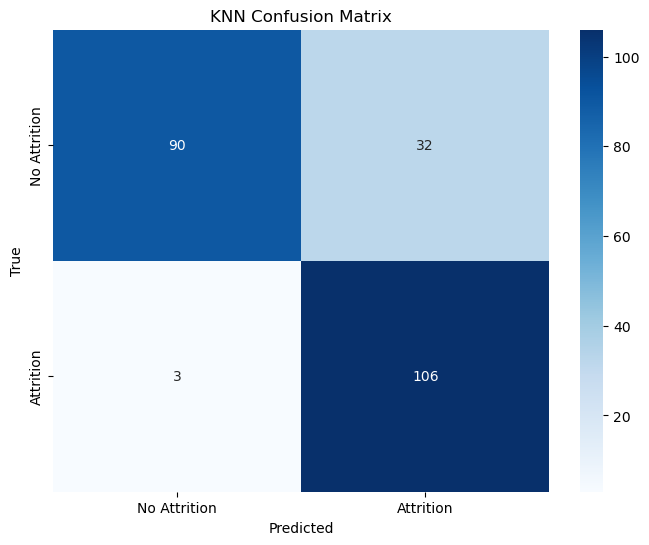

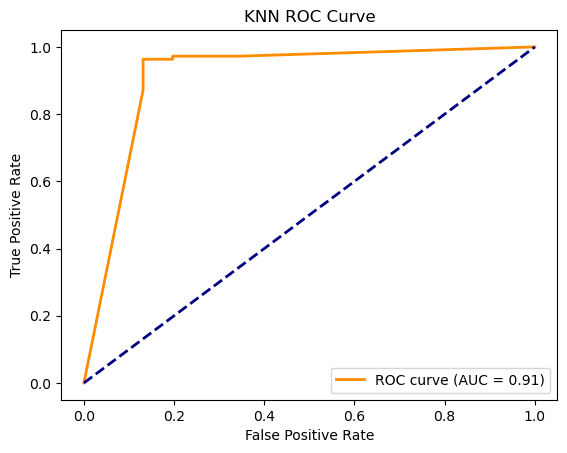

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (45,) and arg 3 with shape (31,).

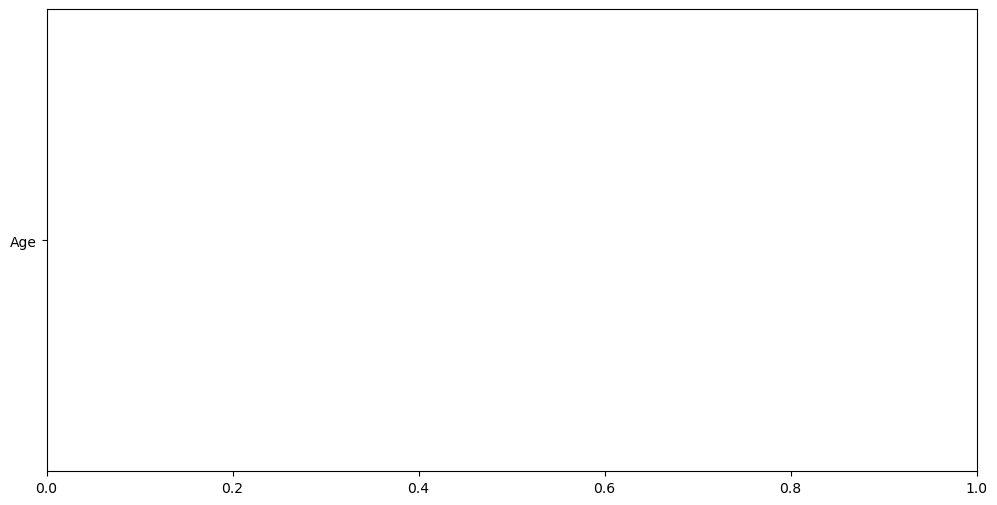

In [2]:
# After running the KNN model code in HR_Project_KNN.ipynb

# 1. Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Attrition', 'Attrition'], 
            yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Feature Importance
plt.figure(figsize=(12,6))
plt.barh(preprocessor.feature_names, importances)
plt.title("KNN Feature Importance via Permutation")
plt.xlabel("Importance Score")
plt.show()

# 4. Validation Curve for k Values
plt.figure(figsize=(10,6))
plt.plot(k_values, train_scores, 'o-', label="Training Score")
plt.plot(k_values, test_scores, 'o-', label="Validation Score")
plt.xlabel("k Value")
plt.ylabel("Accuracy")
plt.title("KNN Validation Curve for k Parameter")
plt.legend()
plt.show()